# LSTM

In [1]:
import numpy as np
import pandas as pd 
import re
import helper
import random
import string
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import pdb

import time
import math

In [2]:
# Run this to reload helper.py so you don't have to restart the kernel
import importlib

importlib.reload(helper)

<module 'helper' from '/Users/glchau/Desktop/Caltech/CS155/loan-sharks/poems/helper.py'>

## Preprocess data

In [3]:
all_words, all_sequences, word_dict, all_sonnet_int = helper.getAllWordsAndSequences("data/shakespeare.txt", "data/Syllable_dictionary.txt")

## Variables and helper functions for RNN training 

In [4]:
all_character_sequences = [' '.join(seq[:-1]) for seq in all_sequences]
all_character_sequences_no_empty = [seq for seq in all_character_sequences if len(seq) > 0]


In [5]:
fixed_length_character_sequences_valid_start = [] 
big_string = ' '.join(all_character_sequences_no_empty)
big_string = ' ' + big_string
step_size = 5
for i in range(0, len(big_string)):
    if (big_string[i-1] == ' ') and (big_string[i] != ' '):
        if len(big_string[i:i+40]) == 40: 
            fixed_length_character_sequences_valid_start.append(big_string[i:i+40])        

In [81]:
[1, 2, 3][:10]

[1, 2, 3]

In [84]:
clipped_sequences = []
for seq in all_character_sequences_no_empty: 
    if (len(seq[:40]) == 40) : 
        clipped_sequences.append(seq[:40]) 

In [7]:
all_letters = string.ascii_lowercase + " '-"  # abcdefghijklmnopqrstuvwxyz '-
n_letters = len(all_letters) + 1 # Plus EOS marker
all_categories = [0] # Only have 1 category for now. We could try to categorize lines by position or ending rhyme
n_categories = len(all_categories)

lens = [len(seq) for seq in fixed_length_character_sequences_valid_start]
max_length = max(lens)
min_lenth = min(lens)
max_length

40

In [125]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
def inputTensor(line):
    # One-hot matrix of first to last letters (not including EOS) for input
    # tensor = torch.zeros(len(line), n_letters)
    # for li in range(len(line)):
    #     letter = line[li]
    #     tensor[li][all_letters.find(letter)] = 1
    
    # Indices 
    letter_indexes = [all_letters.find(line[li]) for li in range(0, len(line))]
    return torch.LongTensor(letter_indexes) #tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

def inputTargetLists(line): 
    inputList = [all_letters.find(line[li]) for li in range(0, len(line))]
    targetList = [all_letters.find(line[li]) for li in range(1, len(line))]
    targetList.append(n_letters - 1)
    return inputList, targetList

In [10]:
# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Generate a batch of lines with input and target tensors 
def randomBatch(category_lines, batch_size=16):
    input_tensors = []
    target_tensors = []
    for b in range(batch_size): 
        line = randomChoice(category_lines)
        inputList, targetList = inputTargetLists(line)
        
        input_tensors.append(inputList)
        target_tensors.append(targetList)
    return torch.LongTensor(input_tensors), torch.LongTensor(target_tensors)

### Training Functions

In [11]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [12]:
# train the RNN on the input and target batch values 

def train_batch(rnn, input_line_tensor, target_line_tensor, optimizer, criterion):
    
    # Put in extra dimension for the "Layer" dimension of LSTM inputs 
    input_line_tensor = torch.unsqueeze(input_line_tensor, dim=0)
    target_line_tensor = torch.unsqueeze(target_line_tensor, dim=0)
    
    # Initilize the hidden and cell matrices 
    hidden, cell = rnn.initHidden()

    # Zero out the gradients for each batch
    rnn.zero_grad()

    # Initlize loss to 0
    loss = 0

    # Iterate through all 40 characters in the sequence
    for i in range(input_line_tensor.size(2)):
        
        # Select only the ith character for the batch
        input_tensor = input_line_tensor[:, :, i] 
        target_tensor = target_line_tensor[:, :, i] 
        
        # Forward pass through RNN 
        output, (hidden, cell) = rnn(input_tensor, (hidden, cell))
        
        # Loss calculation
        l = criterion(torch.squeeze(output, dim=0), torch.squeeze(target_tensor, dim=0))
        loss += l.item() 

        # Compute gradients and take optimizer step
        optimizer.zero_grad()
        l.backward(retain_graph=True)
        optimizer.step()

    return loss / rnn.batch_size

In [13]:
# Sample from a category and starting letter

def sample(rnn, start_letter='a', length=max_length, temperature=1):
    with torch.no_grad():  # no need to track history in sampling
        rnn.eval()
        inputs = inputTensor(start_letter).to(device)
        hidden, cell = torch.zeros(1, 1, rnn.hidden_size).to(device), torch.zeros(1, 1, rnn.hidden_size).to(device)

        output_name = start_letter

        for i in range(length):
            inputs = inputs[None, :]
            
            output, (hidden, cell) = rnn(inputs, (hidden, cell), temperature=temperature)
            
            topi = torch.multinomial(output.data[0], 1)
            # pdb.set_trace()
            # topv, topi = output.topk(1)
            topi = topi[0][0]
            
            # Last index is <EOS> so we just kill the appending
            if topi == n_letters - 1:
                break 
            else:
                letter = all_letters[topi]
                output_name += letter
            
            inputs = inputTensor(letter).to(device)

        return output_name

In [14]:
# Sample from a category and starting letter

def sampleMultipleStart(rnn, start_seq='ant', length=max_length, temperature=1):
    with torch.no_grad():  # no need to track history in sampling
        rnn.eval()
        
        
        hidden, cell = torch.zeros(1, 1, rnn.hidden_size).to(device), torch.zeros(1, 1, rnn.hidden_size).to(device)

        input_array = []
        for char in start_seq: 
            input_array.append(inputTensor(char).to(device))
        output_sequence = start_seq
        
        for i in range(len(start_seq) - 1): 
            inputs = input_array[i][None, :].to(device)
            output, (hidden, cell) = rnn(inputs, (hidden, cell), temperature=temperature)

        inputs = input_array[len(start_seq) - 1][None, :]
        for i in range(length):
            
            output, (hidden, cell) = rnn(inputs, (hidden, cell), temperature=temperature)
            # output = output.data[0] / sum(output.data[0][0]) 
            topi = torch.multinomial(output.data[0], 1)
            
            # topv, topi = output.topk(1)
            topi = topi[0][0]
            
            # Last index is <EOS> so we just kill the appending
            if topi == n_letters - 1:
                break 
            else:
                letter = all_letters[topi]
                output_sequence += letter
            
            inputs = inputTensor(letter)[None, :].to(device)

        return output_sequence

## One Hot encoding LSTM

In [60]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_classes, batch_size, device, n_layers=1): # n_classes is output_size 
        super(RNN, self).__init__()
        self.input_size = input_size # input size is number of classes in our case 
        self.hidden_size = hidden_size # hidden layer size 
        self.n_classes = n_classes # number of classes 
        self.batch_size = batch_size # size of batch
        self.n_layers = n_layers # number of layers in LSTM
        self.device = device # 'cuda' or 'cpu'
        

        # self.embedding = nn.Embedding(input_size, input_size)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1)
        self.decoder = nn.Linear(hidden_size, n_classes)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.Softmax(dim=2)
        

    def forward(self, input_vals, hc, temperature=1):
        # embeding = self.embedding(input_vals)
        one_hot = torch.nn.functional.one_hot(input_vals, num_classes=self.n_classes)
        # pdb.set_trace()
        output, hc = self.lstm(one_hot.float(), hc)
        output = self.decoder(output)
        output = self.dropout(output)
        # pdb.set_trace()
        output = self.softmax(output / temperature)
        return output, (hc[0].detach(), hc[1].detach())

    def initHidden(self, num_layers=None, batch_size=None, hidden_size=None):
        if num_layers is None:
            num_layers = self.n_layers
        if batch_size is None:
            batch_size = self.batch_size
        if hidden_size is None:
            hidden_size = self.hidden_size
            
        return torch.zeros(num_layers, batch_size, hidden_size).to(self.device), torch.zeros(num_layers, batch_size, hidden_size).to(self.device)

In [117]:
######### PARAMETERS #########
batch_size = 32
hidden_size = 128
n_iters = 5000
print_every = 500
plot_every = 500
learning_rate = 0.0005
############################## 

rnn = RNN(n_letters, hidden_size, n_letters, device=device, batch_size=batch_size).to(device) # expand hidden units 

criterion = nn.CrossEntropyLoss() 

optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    try : 
        input_line_tensor, target_line_tensor = randomBatch(clipped_sequences, batch_size=batch_size)
        loss = train_batch(rnn, input_line_tensor.to(device), target_line_tensor.to(device), criterion=criterion, optimizer=optimizer)
        total_loss += loss
    except : 
        print(input_line_tensor)
        raise

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 42s (500 10%) 3.8604
1m 23s (1000 20%) 3.8660
2m 6s (1500 30%) 3.8229
2m 48s (2000 40%) 3.8155
3m 30s (2500 50%) 3.8300
4m 12s (3000 60%) 3.7993
4m 53s (3500 70%) 3.7994
5m 34s (4000 80%) 3.7702
6m 16s (4500 90%) 3.7763
6m 58s (5000 100%) 3.7763


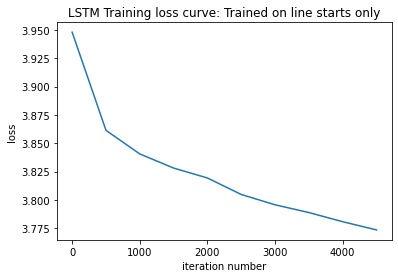

In [119]:
plt.plot(np.arange(0, n_iters, plot_every), all_losses)
plt.ylabel("loss")
plt.xlabel("iteration number")
plt.title("LSTM Training loss curve: Trained on line starts only") 
plt.show()

In [120]:
# Sample a poem
for i in range(14): 
    original_sample = sample(rnn, random.choice(string.ascii_lowercase[:-3]), 
                             length=random.randint(30, 50), temperature=1)
    print(' '.join(original_sample.split(" ")[:-1]))
    if i in [3, 7, 11]:
        print()

an the worl shall the worl shall the
for the worl the worl stare the worl the worl
that the that the worl stare the worth the
kno the worl the worl the worl the

reser the worl the worl the worl
so th that the worl the worl the
doth the worl the worl the worl the when the
gin the worlore that the worl the worl the whes

jor the worl shall the worl shall the
pot the worl the worl the when the worl the when
where that the worl the worl the
or the worl the worl the worl the worl the

hath then the worl the worl the when the that the
even the worl shall the worl shall the worl


In [124]:
# Save model
torch.save(rnn.state_dict(), "./models/lstm_onehot_model_128hdim_10000iters_lineStart.pt")



In [121]:
start_sample = sampleMultipleStart(rnn, start_seq="shall i compare thee to a summer's day", 
                             length=1000, temperature=1.5)

for line in range(14):
    print(' '.join(start_sample.split(" ")[line * 14:line * 14 + 10]))


shall i compare thee to a summer's day the worl
worlore the see the sees that the worl the worl
that the worl the worl the worl the worl the
whe th the the worl shall the worth the worl
worl shall the worl the worl stare the worl the
worl shall the worl the worl stare the se stare
the worl shall the worl the worl the worl the
see the worl the whese that the worl the worl
whese that the worlore that the that the worl the
the worlest the worl the worl stare the worth the
that the worlore that the the that the worth the
worl the where that the worlore that the the worl
the that the worl the worl the worl the worl
worlart the worl the worl the whes that the the


## Embedding LSTM

In [20]:
class RNN_Embedding(nn.Module):
    def __init__(self, input_size, hidden_size, n_classes, device, batch_size, n_layers=1): # n_classes is output_size 
        super(RNN_Embedding, self).__init__()
        self.input_size = input_size # input size is number of classes in our case 
        self.hidden_size = hidden_size # hidden layer size 
        self.n_classes = n_classes # number of classes 
        self.batch_size = batch_size # size of batch
        self.n_layers = n_layers # number of layers in LSTM
        self.device = device # 'cuda' or 'cpu'

        self.embedding = nn.Embedding(input_size, input_size)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=n_layers)
        self.decoder = nn.Linear(hidden_size, n_classes)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.Softmax(dim=2)
        

    def forward(self, input_vals, hc, temperature=1):
        embeding = self.embedding(input_vals)
        # pdb.set_trace()
        output, hc = self.lstm(embeding, hc)
        output = self.decoder(output)
        output = self.dropout(output)
        # pdb.set_trace()
        output = self.softmax(output / temperature)
        return output, (hc[0].detach(), hc[1].detach())

    def initHidden(self, num_layers=None, batch_size=None, hidden_size=None):
        if num_layers is None:
            num_layers = self.n_layers
        if batch_size is None:
            batch_size = self.batch_size
        if hidden_size is None:
            hidden_size = self.hidden_size
            
        return torch.zeros(num_layers, batch_size, hidden_size).to(device), torch.zeros(num_layers, batch_size, hidden_size).to(device)

In [22]:
######### PARAMETERS #########
batch_size = 32
hidden_size = 128
n_iters = 10000
print_every = 500
plot_every = 500
learning_rate = 0.0005
############################## 

rnn_embedding = RNN_Embedding(input_size=n_letters, hidden_size=hidden_size, n_classes=n_letters, n_layers=1, device=device, batch_size=batch_size).to(device) # expand hidden units 

criterion = nn.CrossEntropyLoss() 

optimizer = torch.optim.Adam(rnn_embedding.parameters(), lr=learning_rate)

import pdb

all_losses_embed = []
total_loss_embed = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    try : 
        input_line_tensor, target_line_tensor = randomBatch(fixed_length_character_sequences_valid_start, batch_size=batch_size)
        loss = train_batch(rnn_embedding, input_line_tensor.to(device), target_line_tensor.to(device), criterion=criterion, optimizer=optimizer)
        total_loss_embed += loss
    except : 
        print(input_line_tensor)
        raise

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses_embed.append(total_loss_embed / plot_every)
        total_loss_embed = 0

0m 45s (500 2%) 3.8301
1m 33s (1000 4%) 3.8271
2m 18s (1500 6%) 3.7849
3m 2s (2000 8%) 3.8033
3m 46s (2500 10%) 3.7771
4m 31s (3000 12%) 3.7499
5m 15s (3500 14%) 3.7788
5m 59s (4000 16%) 3.7510
6m 44s (4500 18%) 3.7611
7m 29s (5000 20%) 3.7799
8m 13s (5500 22%) 3.7509
8m 57s (6000 24%) 3.7391
9m 42s (6500 26%) 3.7589
10m 26s (7000 28%) 3.7678
11m 11s (7500 30%) 3.7626
11m 56s (8000 32%) 3.7430
12m 40s (8500 34%) 3.7426
13m 25s (9000 36%) 3.7206
14m 10s (9500 38%) 3.7391
14m 57s (10000 40%) 3.7542
15m 44s (10500 42%) 3.7429
16m 31s (11000 44%) 3.7483
17m 15s (11500 46%) 3.7245
18m 0s (12000 48%) 3.7308
18m 44s (12500 50%) 3.7229
19m 29s (13000 52%) 3.7543
20m 14s (13500 54%) 3.7331
20m 58s (14000 56%) 3.7296
21m 43s (14500 57%) 3.7283
22m 27s (15000 60%) 3.7606
23m 11s (15500 62%) 3.7322
23m 55s (16000 64%) 3.7477
24m 40s (16500 66%) 3.7225
25m 24s (17000 68%) 3.7382
26m 9s (17500 70%) 3.7327
26m 53s (18000 72%) 3.7155
27m 37s (18500 74%) 3.7254
28m 21s (19000 76%) 3.7334
29m 6s (19500 

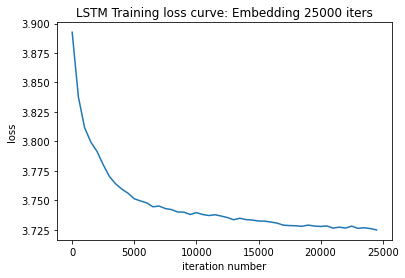

In [101]:
plt.plot(np.arange(0, 25000, 500), all_losses_embed)
plt.ylabel("loss")
plt.xlabel("iteration number")
plt.title("LSTM Training loss curve: Embedding 25000 iters") 
plt.show()

In [26]:
torch.save(rnn_embedding.state_dict(), "./models/lstm_embedding_model_128hdim_25000iters.pt")


In [24]:
# Sample a poem
for i in range(14): 
    original_sample = sample(rnn_embedding, random.choice(string.ascii_lowercase[:-3]), 
                             length=random.randint(30, 50), temperature=3.05)
    print(' '.join(original_sample.split(" ")[:-1]))
    if i in [3, 7, 11]:
        print()

when the star shall shoull the sail the star
love the st the st the s use the st the star the
conter so the stare to the star the st the
not lover the star the st the

eyes the strainter the stares
when the st the star the st the star
doth the stae the st the state the
conter state shoul save the star

of the star the st the star sense the star
verse the one so the star the state
love the st the star seen the state
nour sell the state the star the

juit in the star the st the
part the stare the st the state


In [59]:
start_sample = sampleMultipleStart(rnn_embedding, start_seq="shall i compare thee to a summer's day", 
                             length=1000, temperature=0.75)

for line in range(14):
    print(' '.join(start_sample.split(" ")[line * 14:line * 14 + 10]))


shall i compare thee to a summer's day the star
the star the star the state the st the star
the st the st the st the star the st
the st the st the state the stron the star
st the star the st the stares the star the
st the star the st the star the st the
st the st the state the star the st the
star the stare the star the starest the star the
st the st the star the stare the star the
st the state the state the state the star the
star the star the stare the state the star the
the st the star the star the st the star
the st the star the star the stare the st
the st the star the st the star the st


In [44]:
for line in range(14):
    print(' '.join(start_sample.split(" ")[line * 14:line * 14 + 10]))

shall i compare thee to a summer's day the star
the star the star the st the star the st
the stron the st the star the st the star
the st the star the star the st the star
the st the star the st the st the st
the state the star the star the st the st
the state the star the star the st the star
the star the star the st the star the star
the stare the state the star the stare the state
the star the stare the state the strest the star
so the st the star the st the st the
st the st the state the star the st the
star the star the state the st the star the
stares the state the starest the stares the star the


In [ ]:
# Load model
# Model class must be defined somewhere
rnn_load_model = RNN_Embedding(n_letters, hidden_size, n_letters, device=device, batch_size=batch_size)
rnn_load_model.load_state_dict(torch.load("./models/lstm_embedding_model.pt"))
rnn_load_model.eval()